In [0]:
from google.colab import drive,files

In [2]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
# Imports go here

import pickle
import numpy as np
from keras.utils import plot_model
from keras.models import Sequential
from keras.models import Model
from keras.optimizers import Adam
from keras.optimizers import Nadam
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense, Activation,BatchNormalization
import pandas as pd
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import functools

Using TensorFlow backend.


In [0]:
# Training,Validation and Test directory paths

pickletraindata_X = 'gdrive/My Drive/DL Project/PickleFiles/vgg_features_train_full.pkl'
picklevaldata_X = 'gdrive/My Drive/DL Project/PickleFiles/vgg_features_val_full.pkl'
pickletestdata_X = 'gdrive/My Drive/DL Project/PickleFiles/vgg_features_test_full.pkl'

pickletraindata_Y1 = 'gdrive/My Drive/DL Project/PickleFiles/pickleTrainFull_Y1.pkl'
picklevaldata_Y1 = 'gdrive/My Drive/DL Project/PickleFiles/pickleValFull_Y1.pkl'
pickletestdata_Y1 = 'gdrive/My Drive/DL Project/PickleFiles/pickleTestFull_Y1.pkl'

pickletraindata_Y2 = 'gdrive/My Drive/DL Project/PickleFiles/pickleTrainFull_Y2.pkl'
picklevaldata_Y2 = 'gdrive/My Drive/DL Project/PickleFiles/pickleValFull_Y2.pkl'
pickletestdata_Y2 = 'gdrive/My Drive/DL Project/PickleFiles/pickleTestFull_Y2.pkl'


In [5]:
# Reading train_X into the session

train_X_list = pickle.load(open(pickletraindata_X, 'rb' ))
train_X = np.array(train_X_list)
train_X=train_X.reshape(len(train_X_list),7,7,512)
print(train_X.shape)

(66071, 7, 7, 512)


In [6]:
# Reading train_Y1 into the session

train_Y1_list = pickle.load(open(pickletraindata_Y1, 'rb' ))
train_Y1 = np.array(train_Y1_list)
print(train_Y1.shape)

(66071, 172)


In [7]:
# Reading train_Y2 into the session

train_Y2_list = pickle.load(open(pickletraindata_Y2, 'rb' ))
train_Y2 = np.array(train_Y2_list)

for index in range(train_Y2.shape[0]):
  templist = train_Y2[index]
  templist_0 = [0 if x==-1 else x for x in templist]
  train_Y2[index] = templist_0

print(train_Y2.shape)

(66071, 353)


In [8]:
# Reading validation X into the session

val_X_list = pickle.load(open(picklevaldata_X, 'rb' ))
val_X = np.array(val_X_list)
val_X = val_X.reshape(len(val_X_list),7,7,512)
print(val_X.shape)

(11016, 7, 7, 512)


In [9]:
# Reading validation Y1 into the session

val_Y1_list = pickle.load(open(picklevaldata_Y1, 'rb' ))
val_Y1 = np.array(val_Y1_list)
print(val_Y1.shape)

(11016, 172)


In [10]:
# Reading validation Y2 into the session

val_Y2_list = pickle.load(open(picklevaldata_Y2, 'rb' ))
val_Y2 = np.array(val_Y2_list)

for index in range(val_Y2.shape[0]):
  templist = val_Y2[index]
  templist_0 = [0 if x==-1 else x for x in templist]
  val_Y2[index] = templist_0
  
print(val_Y2.shape)

(11016, 353)


In [7]:
# Reading test X into the session

test_X_list = pickle.load(open(pickletestdata_X, 'rb' ))
test_X = np.array(test_X_list)
test_X=test_X.reshape(len(test_X_list),7,7,512)
print(test_X.shape)

(33154, 7, 7, 512)


In [8]:
# Reading test Y1 into the session

test_Y1_list = pickle.load(open(pickletestdata_Y1, 'rb' ))
test_Y1 = np.array(test_Y1_list)
print(test_Y1.shape)

(33154, 172)


In [9]:
# Reading test Y2 into the session

test_Y2_list = pickle.load(open(pickletestdata_Y2, 'rb' ))
test_Y2 = np.array(test_Y2_list)

for index in range(test_Y2.shape[0]):
  templist = test_Y2[index]
  templist_0 = [0 if x==-1 else x for x in templist]
  test_Y2[index] = templist_0

print(test_Y2.shape)

(33154, 353)


In [0]:
# Defining validation metrics for the model

def get_f1(y_true, y_pred):
  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  recall = true_positives / (possible_positives + K.epsilon())
  f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
  return f1_val

top5_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=5)
top5_acc.__name__ = 'top5_acc'

#### Model Architecture D : This is an architecure for Multi-Task learning where the tasks Food Category Identification and Ingredient Recognition are sharing lower convolutional layers and have their seperate upper convolutional layers and dense layers and there are 2 outputs and loss function for the model to optimize.






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 7, 7, 512)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 7, 7, 2048)   9439232     input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 4, 4, 2048)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4, 4, 2048)   0           max_po

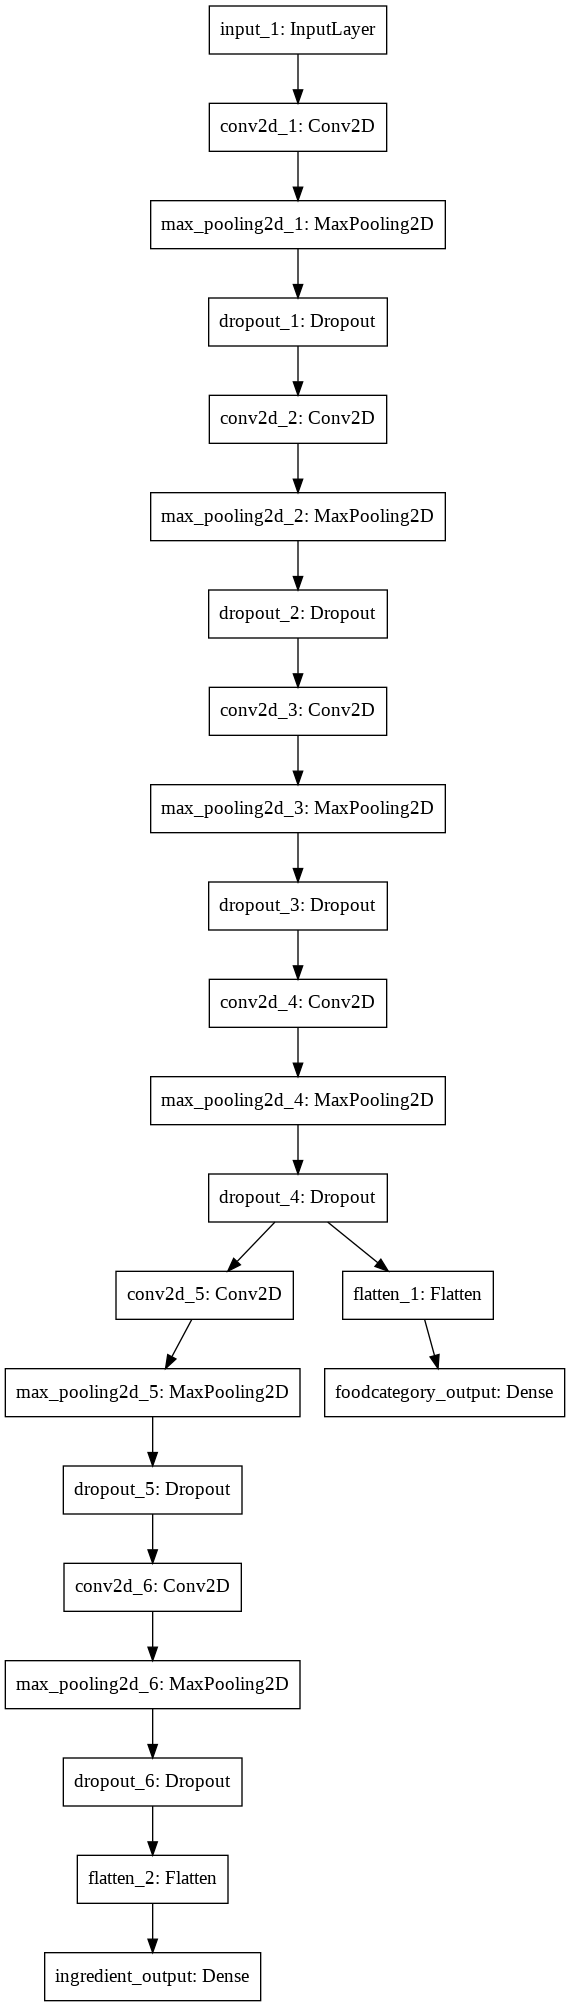

In [15]:
# Defining Architecture D

inputs = Input(shape=(7,7,512))
 
conv2D1 = Conv2D(2048, kernel_size=3, activation='relu',padding='same')(inputs)
maxPool2D1 = MaxPooling2D(pool_size=(2,2),padding='same')(conv2D1)
dropout1 = Dropout(0.5)(maxPool2D1)

conv2D2 =  Conv2D(1024, kernel_size=3, activation='relu',padding='same')(dropout1)
maxPool2D2 = MaxPooling2D(pool_size=(2,2),padding='same')(conv2D2)
dropout2 = Dropout(0.5)(maxPool2D2)

conv2D3 = Conv2D(1024, kernel_size=3, activation='relu',padding='same')(dropout2)
maxPool2D3 = MaxPooling2D(pool_size=(2,2),padding='same')(conv2D3)
dropout3 = Dropout(0.5)(maxPool2D3)

conv2D4 = Conv2D(512, kernel_size=3, activation='relu',padding='same')(dropout3)
maxPool2D4 = MaxPooling2D(pool_size=(2,2),padding='same')(conv2D4)
dropout4 = Dropout(0.5)(maxPool2D4)

conv2D5 = Conv2D(1024, kernel_size=3, activation='relu',padding='same')(dropout4)
maxPool2D5 = MaxPooling2D(pool_size=(2,2),padding='same')(conv2D5)
dropout5 = Dropout(0.7)(maxPool2D5)

conv2D6 = Conv2D(512, kernel_size=3, activation='relu',padding='same')(dropout5)
maxPool2D6 = MaxPooling2D(pool_size=(2,2),padding='same')(conv2D6)
dropout6 = Dropout(0.5)(maxPool2D6)

flattened4= Flatten()(dropout4)
flattened6 = Flatten()(dropout6)

output1 = Dense(353,activation='sigmoid',name='ingredient_output')(flattened6)  ##  Ingredient recognition
output2 = Dense(172,activation='softmax',name='foodcategory_output')(flattened4) ##  Food categorization

model_D = Model(inputs=inputs, outputs=[output1,output2]) # Defining model with Architecture A1
print(model_D.summary()) # summarize layers
plot_model(model_D, to_file='Multi-task Architecture d for food Categorization and Ingredient Recognition.png') # plot graph

In [16]:
# Defining loss fuction and optimizer

model_D.compile(optimizer=Adam(lr=0.0005),
              loss={'ingredient_output': 'binary_crossentropy', 'foodcategory_output': 'categorical_crossentropy'},
              #loss_weights={'ingredient_output': 0.8, 'foodcategory_output': 0.2},
              metrics=[get_f1,top5_acc])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
history = model_D.fit(train_X, [train_Y2,train_Y1], batch_size=256, epochs=50,validation_data = (val_X, [val_Y2, val_Y1]))




Train on 66071 samples, validate on 11016 samples
Epoch 1/50





66071/66071 [==============================] - 51s 765us/step - loss: 16.0571 - ingredient_output_loss: 0.0817 - foodcategory_output_loss: 15.9754 - ingredient_output_get_f1: 0.0191 - ingredient_output_top5_acc: 0.2025 - foodcategory_output_get_f1: 0.0082 - foodcategory_output_top5_acc: 0.9201 - val_loss: 16.0391 - val_ingredient_output_loss: 0.0614 - val_foodcategory_output_loss: 15.9776 - val_ingredient_output_get_f1: 0.0000e+00 - val_ingredient_output_top5_acc: 0.3884 - val_foodcategory_output_get_f1: 0.0087 - val_foodcategory_output_top5_acc: 0.9561
Epoch 2/50
66071/66071 [==============================] - 35s 527us/step - loss: 8.9981 - ingredient_output_loss: 0.0524 - foodcategory_output_loss: 8.9457 - ingredient_output_get_f1: 5.6951e-04 - ingredient_output_top5_acc: 0.3460 - foodcategory_output_get_f1: 0.0063 - foodcategory_output_top5_acc: 0.2415 - val_loss: 4.4876 - val_ingredient_output_loss: 0.0411 - val_f

In [0]:
# Serialize model to JSON and save
model_json = model_D.to_json()
with open('gdrive/My Drive/DL Project/models_latest/Architecture_D.json', "w") as json_file:
    json_file.write(model_json)

# Serialize weights to HDF5
model_D.save_weights('gdrive/My Drive/DL Project/models_latest/Architecture_D.h5')
print("Saved model to disk")

In [0]:
# Plotting the train,validation accuracy and loss statistics for ingredient identification.

fig = plt.figure(figsize=(12,6))

plt.subplot(1, 3, 1)
plt.plot(history.history['ingredient_output_get_f1'])
plt.plot(history.history['val_ingredient_output_get_f1'])
plt.title('Macro-f1 for Ingredient recognition')
plt.ylabel('Macro-f1')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1, 3, 2)
plt.plot(history.history['ingredient_output_top5_acc'])
plt.plot(history.history['val_ingredient_output_top5_acc'])
plt.title('Top-5 accuracy for Ingredient recognition')
plt.ylabel('Top-5 accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1, 3, 3)
plt.plot(history.history['foodcategory_output_top5_acc'])
plt.plot(history.history['val_foodcategory_output_top5_acc'])
plt.title('Top-5 accuracy for Food Category')
plt.ylabel('Top-5 accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

In [10]:
# Import the saved model in a new session:

from keras.models import model_from_json
# load json and create model
json_file = open('gdrive/My Drive/DL Project/models_latest/Architecture_D.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('gdrive/My Drive/DL Project/models_latest/Architecture_D.h5')
print("Loaded model from disk")






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.






Loaded model from disk


In [0]:
loaded_model

In [0]:
loaded_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0005), metrics=[get_f1,top5_acc])

In [24]:
results = loaded_model.evaluate(test_X, [test_Y2,test_Y1], batch_size=128)
print('Ingredient F1:', results[3])
print('Ingredient Top5:', results[4])
print('Food F1:', results[5])
print('Food Top5:', results[6])


33154/33154 [==============================] - 7s 210us/step
Ingredient F1: 0.46880688174049784
Ingredient Top5: 0.6663449357543585
Food F1: 0.5822505667628587
Food Top5: 0.8395970320323339


In [0]:
# Making predictions on test data

predictions = loaded_model.predict(test_X)
predictions_ingredients=1*(predictions[0] >= 0.5)

In [26]:
# Generating classification report

from sklearn.metrics import classification_report
print(classification_report(test_Y2, predictions_ingredients))

              precision    recall  f1-score   support

           0       0.75      0.14      0.24      6698
           1       0.73      0.23      0.35       666
           2       0.35      0.01      0.02       731
           3       0.76      0.45      0.57       144
           4       0.73      0.54      0.62       435
           5       0.00      0.00      0.00        10
           6       0.00      0.00      0.00        24
           7       0.00      0.00      0.00        46
           8       0.64      0.32      0.42       868
           9       0.20      0.00      0.01       365
          10       0.00      0.00      0.00        41
          11       0.77      0.15      0.25       699
          12       0.64      0.07      0.13       387
          13       0.71      0.16      0.26      1639
          14       0.00      0.00      0.00        76
          15       0.82      0.16      0.27      4353
          16       0.61      0.02      0.05      1138
          17       0.74    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
